In [20]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score
import numpy as np
import torch

from utils import BinaryLovaszHingeLoss, DiceLoss, JaccardLoss, dice_coefficient, show_images_and_masks
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fix seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True




In [21]:
torch.cuda.empty_cache()


In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, augment=False, denoise=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.denoise = denoise
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
        self.augment = augment

        self.augment_transform = A.Compose([
            A.OneOf([
                A.Rotate(limit=180, p=0.5),
                A.ElasticTransform(alpha=10, sigma=50, alpha_affine=80, p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=45, p=0.30),
            ], p=1.0),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.GaussianBlur(blur_limit=3, p=0.5),
            A.GaussNoise(var_limit=(10, 50), p=0.20),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomResizedCrop(height=512, width=512, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.15),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(30,30), p=1),
            #A.CoarseDropout(max_holes=16, max_height=50, max_width=40, min_holes=8, min_height=20, min_width=20, fill_value=0, p=0.5),
            A.ToFloat(max_value=255.0),
            ToTensorV2(),
        ])


        self.basic_transform = A.Compose([
            A.CLAHE(clip_limit=4.0, tile_grid_size=(30,30), p=1),
            A.ToFloat(max_value=255.0),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        mask_path = os.path.join(self.mask_dir, image_filename.replace('image', 'mask'))

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.denoise:
            image = cv2.fastNlMeansDenoising(image, None, h=15, templateWindowSize=7, searchWindowSize=21)

        image_pil = Image.fromarray(image).convert('RGB')  
        mask_pil = Image.fromarray(mask)

        image_pil = image_pil.resize((512, 512), Image.LANCZOS)
        mask_pil = mask_pil.resize((512, 512), Image.LANCZOS)

        image = np.array(image_pil)
        mask = np.array(mask_pil)
        _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)


        if self.augment:
            augmented = self.augment_transform(image=image, mask=mask)
        else:
            augmented = self.basic_transform(image=image, mask=mask)

        image = augmented['image']
        mask = augmented['mask']

        return image, mask.float()


In [23]:
def freeze_all_encoder_layers(model):
    for layer in model.down_blocks:
        for param in layer.parameters():
            param.requires_grad = False


In [24]:
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [25]:
def unfreeze_block(model, block_name):
    """
    Unfreezes a specific block of the ResNet encoder within the U-Net model.

    Parameters:
    - model: The instance of your UNetWithResnet50Encoder model.
    - block_name: A string name of the block to unfreeze (e.g., 'layer4', 'layer3').
    """
    if hasattr(model, 'down_blocks'):
        for block in model.down_blocks:
            # The down_blocks attribute is a ModuleList; each block is a layer in ResNet
            if block_name == block.__class__.__name__:
                for param in block.parameters():
                    param.requires_grad = True
    else:
        print(f"The model does not have the specified block: {block_name}")


# Prediction

In [26]:
import matplotlib.pyplot as plt

def visualize(image, true_mask=None, predicted_mask=None):
    """Visualize comparison between input image, true mask, and predicted mask."""
    fig, axs = plt.subplots(1, 3, figsize=(20, 10)) 

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    if true_mask is not None:
        axs[1].imshow(true_mask, cmap='gray')
        axs[1].set_title('True Mask')
        axs[1].axis('off')
    else:
        axs[1].axis('off')

    axs[2].imshow(predicted_mask, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')

    plt.show()


In [27]:
def predict_and_visualize(model, dataset, device, n_images):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for i in range(n_images):
            input_img, true_mask = dataset[i]
            input_img_unsqueeze = input_img.unsqueeze(0).to(device)

            # Predict
            pred_mask_logits = model(input_img_unsqueeze)
            pred_mask_prob = torch.sigmoid(pred_mask_logits)
            pred_mask = pred_mask_prob > 0.5 

            # Calculate Dice Coefficient
            pred = pred_mask.squeeze()
            dice_score = dice_coefficient(pred, true_mask.to(device), smooth=1e-6)

            dice_scores.append(dice_score.item())

            # Convert for visualization
            pred_mask_np = pred_mask.squeeze().cpu().numpy() 
            input_img_np = input_img.squeeze().permute(1, 2, 0).cpu().numpy()
            input_img_np = (input_img_np * 255).astype(np.uint8)
            true_mask_np = true_mask.squeeze().cpu().numpy() if true_mask is not None else None 

            visualize(
                image=input_img_np, 
                true_mask=true_mask_np,
                predicted_mask=pred_mask_np
            )

    # Print the average Dice score at the end 
    average_dice_score = np.mean(dice_scores) 
    print(f'Average Dice Coefficient over {n_images} images: {average_dice_score:.4f}')


In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score


def compute_specificity(y_true, y_pred):
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

def evaluate_model(model, dataset, device):
    model.eval()
    dice_scores = []

    f1_scores = []
    ious = []


    with torch.no_grad():
        for input_img, true_mask in dataset:
            input_img = input_img.unsqueeze(0).to(device)
            true_mask = true_mask.unsqueeze(0).to(device)

            # Forward pass
            output = model(input_img)
            pred_mask_prob = torch.sigmoid(output)
            pred_mask = (pred_mask_prob > 0.5).float()

            # Flatten the tensors for compatibility with sklearn metrics
            y_true = true_mask.view(-1).cpu().numpy()
            y_pred = pred_mask.view(-1).cpu().numpy()

            # Compute metrics
            f1 = f1_score(y_true, y_pred, zero_division=1)
            dice_score = dice_coefficient(pred_mask, true_mask, smooth=1e-6).item()
            iou = jaccard_score(y_true, y_pred, zero_division=1)

            # Append metrics
            f1_scores.append(f1)
            dice_scores.append(dice_score)
            ious.append(iou)

    # Compute mean of all metrics
    metrics = {
        'Mean F1 Score': np.mean(f1_scores),
        'Mean Dice Coefficient': np.mean(dice_scores),
        'Mean IoU': np.mean(ious)
    }
    return metrics



In [31]:
from R2Attention_unet import R2AttU_Net
from resnet152_attention_unet import RAUNet
from resnet152_unet import UNetWithResnet152Encoder
from resnet152_unet_SEB import UNetWithResnet152Encoder as UNetWithResnet152Encoder_SEB

from torchinfo import summary

name_model = 'tuned_resnet152_attention_unet_power_dice_dice'

test_dataset = CustomDataset('../data_model_V5/test/images', '../data_model_V5/test/masks', augment=False, denoise=False)

#model = UNetWithResnet152Encoder(n_classes=1).to(device)
#model = R2AttU_Net(img_ch=3, output_ch=1).to(device)
model = RAUNet(num_classes=1, num_channels=3, pretrained=True).to(device)
#model = UNetWithResnet152Encoder_SEB(n_classes=1).to(device)
model.load_state_dict(torch.load(f'output_NEW/{name_model}.pth'))
model.eval()

print(summary(model, input_size=(1, 3, 512, 512)))


metrics = evaluate_model(model, test_dataset, device)

for metric_name, metric_value in metrics.items():
    print(f'{metric_name}: {metric_value:.4f}')

#predict_and_visualize(model, test_dataset, device, n_images=len(test_dataset))

C:\Users\alois\AppData\Roaming\Python\Python311\site-packages\albumentations\augmentations\blur\transforms.py:189: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
RAUNet                                   [1, 1, 512, 512]          --
├─Conv2d: 1-1                            [1, 64, 256, 256]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 256, 256]         128
├─ReLU: 1-3                              [1, 64, 256, 256]         --
├─MaxPool2d: 1-4                         [1, 64, 128, 128]         --
├─Sequential: 1-5                        [1, 256, 128, 128]        --
│    └─Bottleneck: 2-1                   [1, 256, 128, 128]        --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│ 

KeyboardInterrupt: 

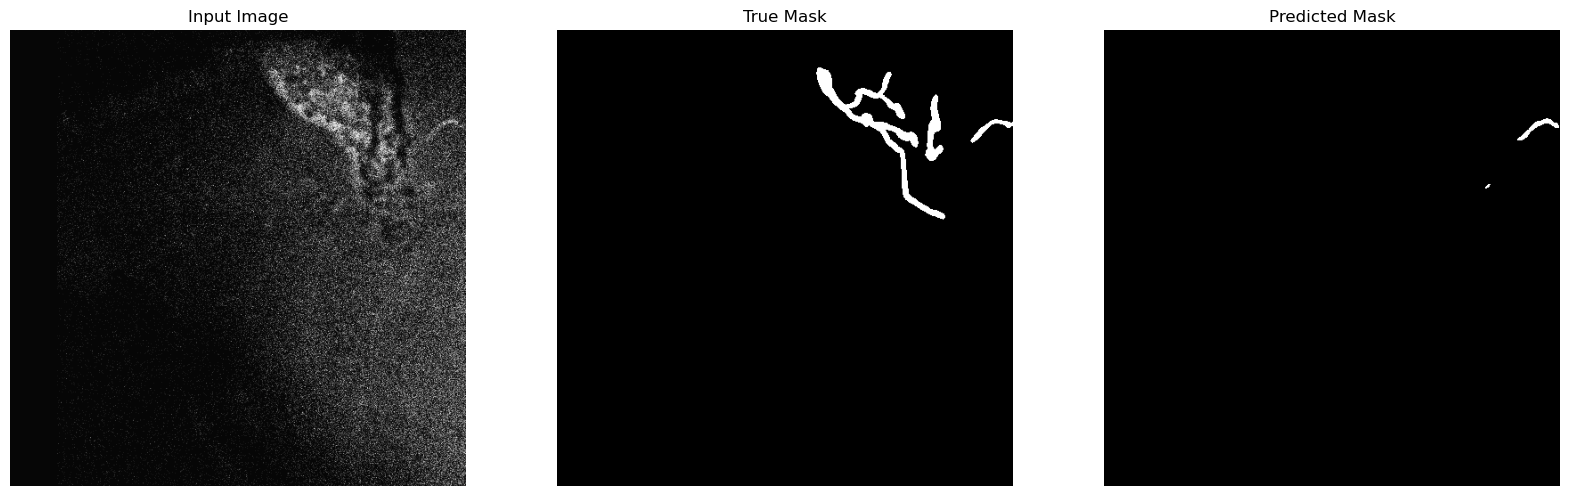

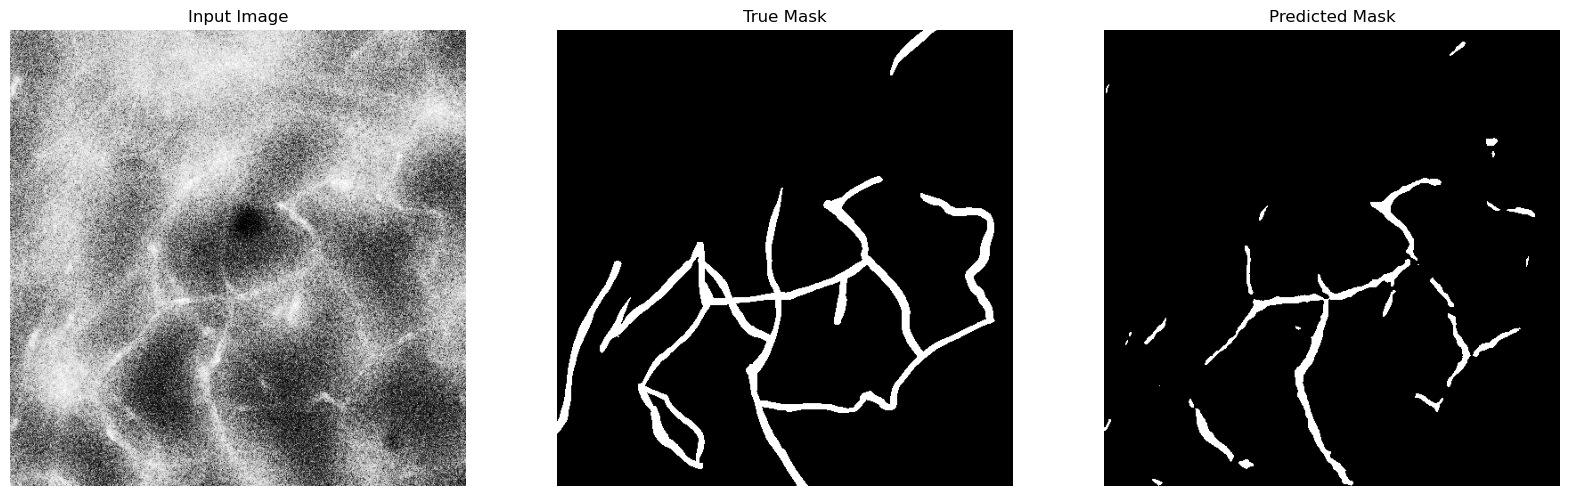

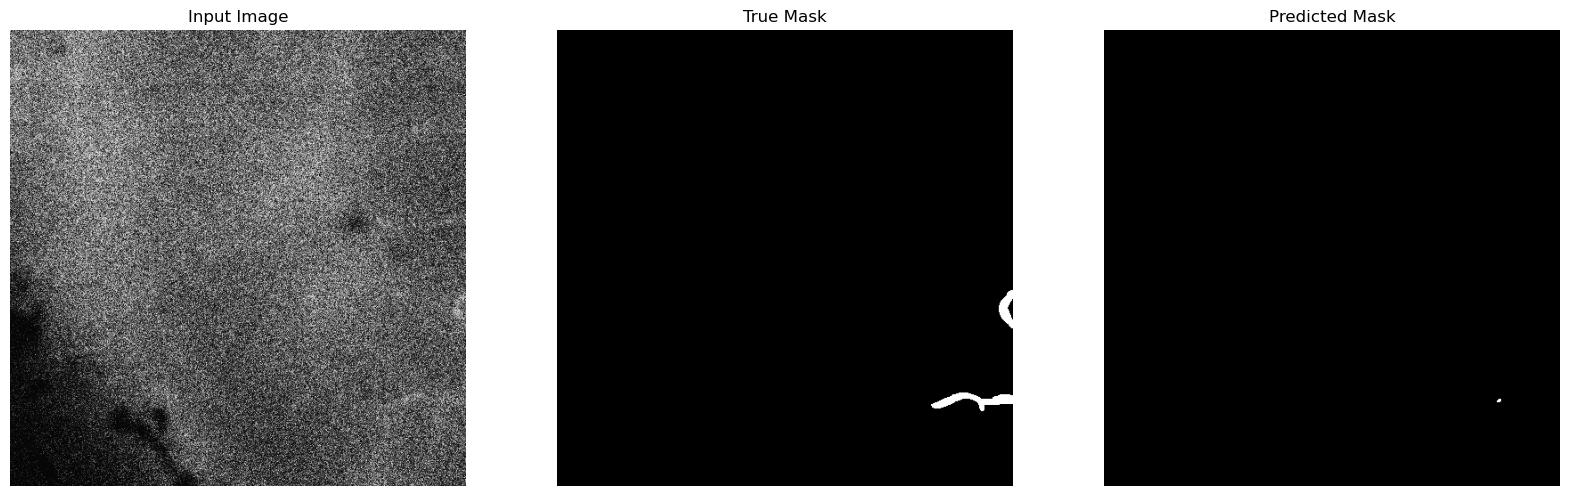

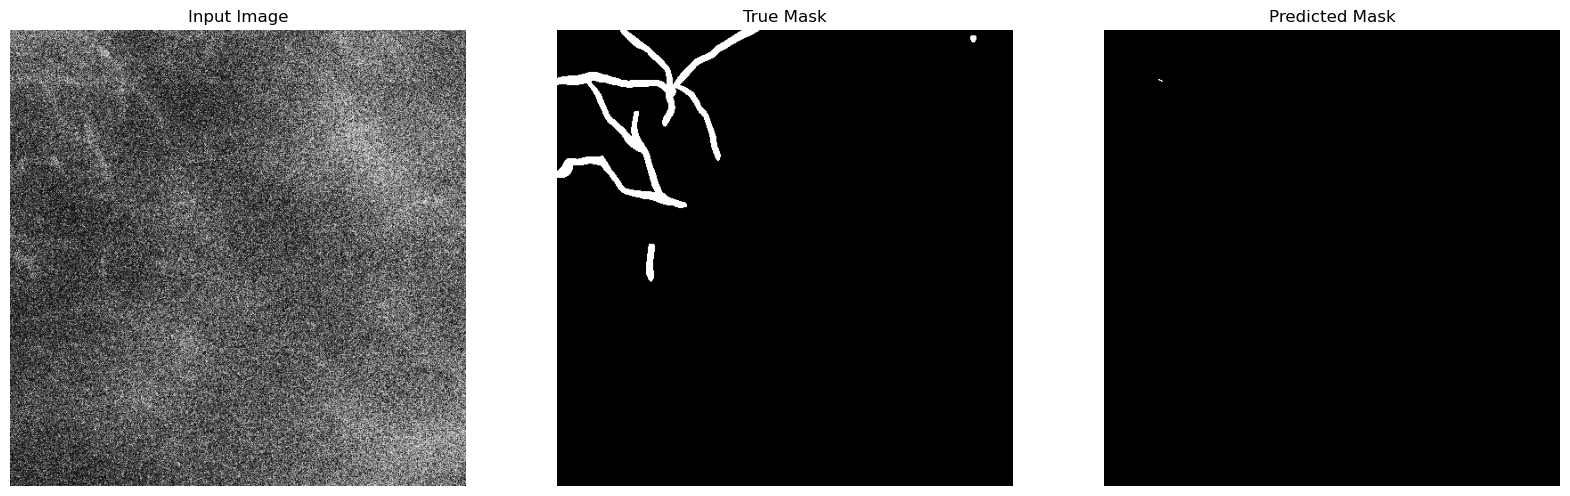

KeyboardInterrupt: 

In [30]:
predict_and_visualize(model, test_dataset, device, n_images=len(test_dataset))

# Ensemble

In [ ]:
def predict_and_visualizes(models, dataset, device, n_images):
    for model in models:
        model.eval()
    
    dice_scores = []
    with torch.no_grad():
        for i in range(n_images):
            input_img, true_mask = dataset[i]
            input_img_unsqueeze = input_img.unsqueeze(0).to(device)
            sum_pred_masks = 0

            # Ensemble Predict
            for model in models:
                pred_mask_logits = model(input_img_unsqueeze)
                pred_mask_prob = torch.sigmoid(pred_mask_logits)
                pred_mask = (pred_mask_prob > 0.5).float()
                sum_pred_masks += pred_mask

            # Majority voting or thresholding
            final_pred_mask = (sum_pred_masks > len(models) // 2).float() 

            # Calculate Dice Coefficient
            pred = final_pred_mask.squeeze()
            dice_score = dice_coefficient(pred, true_mask.to(device), smooth=1e-6)
            dice_scores.append(dice_score.item())

            # Convert for visualization
            final_pred_mask_np = final_pred_mask.squeeze().cpu().numpy()
            input_img_np = input_img.squeeze().permute(1, 2, 0).cpu().numpy()
            input_img_np = (input_img_np * 255).astype(np.uint8)
            true_mask_np = true_mask.squeeze().cpu().numpy() if true_mask is not None else None

            visualize(
                image=input_img_np,
                true_mask=true_mask_np,
                predicted_mask=final_pred_mask_np
            )

    # Print the average Dice score at the end
    average_dice_score = np.mean(dice_scores)
    print(f'Average Dice Coefficient over {n_images} images: {average_dice_score:.4f}')


In [ ]:
import torch
import numpy as np
from sklearn.metrics import f1_score, jaccard_score

def evaluate_models(models, dataset, device):
    for model in models:
        model.eval()

    dice_scores = []
    f1_scores = []
    ious = []

    with torch.no_grad():
        for input_img, true_mask in dataset:
            input_img = input_img.unsqueeze(0).to(device)
            true_mask = true_mask.unsqueeze(0).to(device)
            avg_pred_prob = 0

            for model in models:
                output = model(input_img)
                pred_mask_prob = torch.sigmoid(output)
                avg_pred_prob += pred_mask_prob / len(models)

            # Thresholding the averaged probability map
            final_pred_mask = (avg_pred_prob > 0.5).float()

            # Flatten the tensors for compatibility with sklearn metrics
            y_true = true_mask.view(-1).cpu().numpy()
            y_pred = final_pred_mask.view(-1).cpu().numpy()

            # Compute metrics
            f1 = f1_score(y_true, y_pred, zero_division=1)
            dice_score = dice_coefficient(final_pred_mask, true_mask, smooth=1e-6).item()
            iou = jaccard_score(y_true, y_pred, zero_division=1)

            # Append metrics
            f1_scores.append(f1)
            dice_scores.append(dice_score)
            ious.append(iou)

    # Compute mean of all metrics
    metrics = {
        'Mean F1 Score': np.mean(f1_scores),
        'Mean Dice Coefficient': np.mean(dice_scores),
        'Mean IoU': np.mean(ious)
    }
    return metrics



In [ ]:
from R2Attention_unet import R2AttU_Net
from resnet152_attention_unet import RAUNet
from resnet152_unet import UNetWithResnet152Encoder

name_model1 = 'tuned_resnet152_attention_unet_power_dice_dice'
name_model2 = 'resnet152_SEB_V5'
name_model3 = 'best_model_DRIVE_tuned152'
name_model5 = 'tuned_resnet152_attention_unet_power_jaccard'

test_dataset = CustomDataset('../data_model_V2/test/images', '../data_model_V2/test/masks', augment=False, denoise=False)

#model = UNetWithResnet152Encoder(n_classes=1).to(device)
#model = R2AttU_Net(img_ch=3, output_ch=1).to(device)
model1 = RAUNet(num_classes=1, num_channels=3, pretrained=True).to(device)
model1.load_state_dict(torch.load(f'output_NEW/{name_model1}.pth'))
model1.eval()

model2 = UNetWithResnet152Encoder_SEB(n_classes=1).to(device)
model2.load_state_dict(torch.load(f'output_NEW/{name_model2}.pth'))
model2.eval()

model3 = UNetWithResnet152Encoder(n_classes=1).to(device)
model3.load_state_dict(torch.load(f'output_dir/{name_model3}.pth'))
model3.eval()

                            
                                            
model5 = RAUNet(num_classes=1, num_channels=3, pretrained=True).to(device)
model5.load_state_dict(torch.load(f'output_NEW/{name_model5}.pth'))
model5.eval()

model_list = [model1, model2, model3, model5]
metrics = evaluate_models(model_list, test_dataset, device)

for metric_name, metric_value in metrics.items():
    print(f'{metric_name}: {metric_value:.4f}')

#predict_and_visualizes(model_list, test_dataset, device, n_images=len(test_dataset))

C:\Users\alois\AppData\Roaming\Python\Python311\site-packages\albumentations\augmentations\blur\transforms.py:189: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


Mean F1 Score: 0.5298
Mean Dice Coefficient: 0.5298
Mean IoU: 0.3853
